In [11]:
# load the relevant modules for the analysis

import os
from pathlib import Path

import emcee
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from pl_temp_fit import config_utils

os.chdir("/media/mohammed/Work/Work/pl_temp_fit/")
# access the right directory
# os.chdir('C:\\Users\\ma11115\\OneDrive - Imperial College London\\pl_temp_fit')

In [12]:
databse_path = Path("fit_experimental_emcee_el/fit_data_base/")
json_files = list(databse_path.glob("*.json"))
list_model_config = []
for id, json_file in enumerate(json_files):
    model_config, model_config_save = config_utils.load_model_config(
        json_file.name.replace(".json", ""),
        database_folder=databse_path,
    )

    if Path(model_config_save["save_folder"] + "/sampler.h5").exists():
        filename = model_config_save["save_folder"] + "/sampler.h5"
        try:
            reader = emcee.backends.HDFBackend(filename, name="multi_core")
            distribution = reader.get_chain(flat=True)
        except AttributeError:
            print("checking if the file contains single core data")
            reader = emcee.backends.HDFBackend(filename, name="single_core")
            distribution = reader.get_chain(flat=True)
        true_parameters = list(np.mean(distribution, axis=0))
        model_config_save["mean"] = [f"{x:.3f}" for x in true_parameters]
        model_config_save["num_iteration"] = reader.iteration
        log_prob = reader.get_log_prob(flat=True)
        model_config_save["max_log_prob"] = np.max(log_prob)

        list_model_config.append(model_config_save)

df_all = pd.DataFrame(list_model_config)
df_all.sort_values(by="date", ascending=False, inplace=True)
df_all[["csv_name_pl", "num_iteration", "max_log_prob"]]

,csv_name_pl,num_iteration,max_log_prob
0,/media/mohammed/Work/Work/pl_temp_fit/experiem...,4731,-1275.650933


In [13]:
index_analyse = 0
test_id = df_all["test_id"].loc[index_analyse]
model_config, model_config_save = config_utils.load_model_config(
    test_id, database_folder=databse_path
)
filename = model_config_save["save_folder"] + "/sampler.h5"
reader = emcee.backends.HDFBackend(filename, name="multi_core")
distribution = reader.get_chain(discard=0, flat=True)

number of iterations 4731
-1275.650932681302


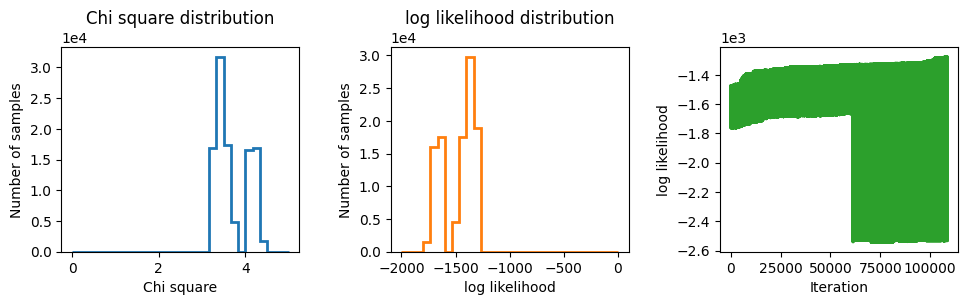

In [14]:
import importlib

from pl_temp_fit import plot_utils

importlib.reload(plot_utils)
plot_utils.plot_fit_statistics(
    reader,
    range_log_prior=(-2000, 0),
    discard=1200,
    range_chi_square=(0, 5),
    filter_log_likelihood=True,
)

-1275.650932681302
-1275.650932681302
-1275.650932681302
-1275.650932681302
-1275.650932681302
-1275.650932681302
-1275.650932681302
-1275.650932681302
-1275.650932681302
-1275.650932681302
-1275.650932681302


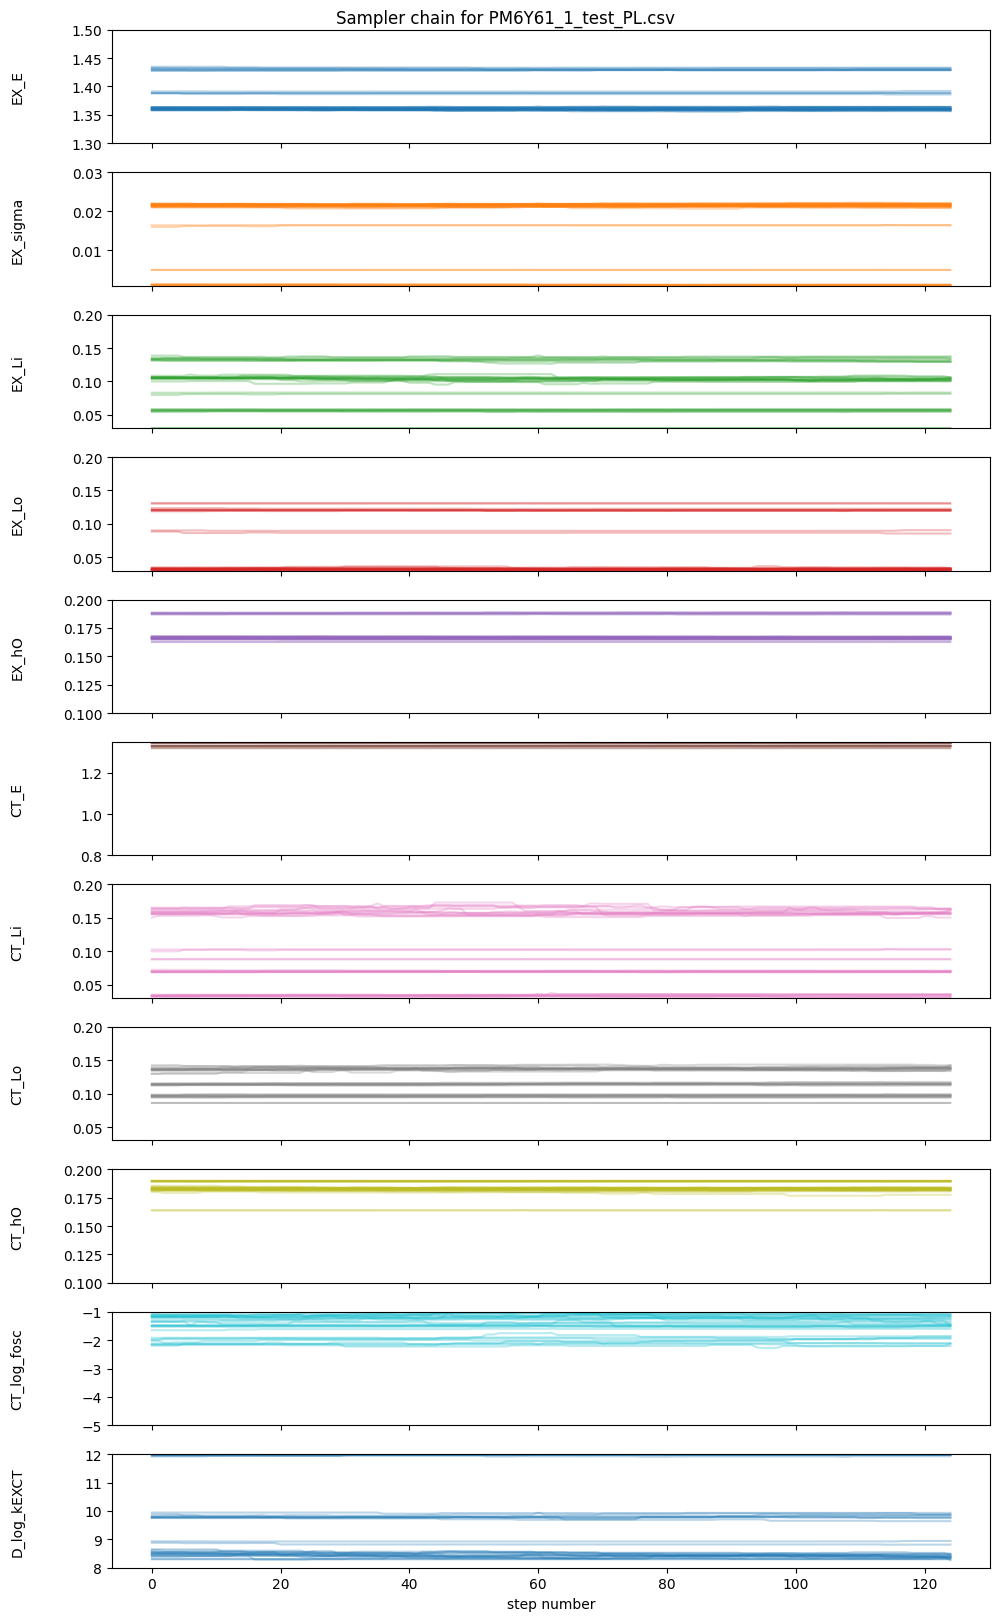

In [15]:
def plot_chains(
    reader, model_config_save, discard=50, filter_log_likelihood=True
):
    """Plot the chains from the sampling output
    reader: the reader object from the emcee sampler
    model_config_save: the model config save dictionary
    discard: the number of samples to discard
    """
    csv_name = model_config_save["csv_name_pl"]
    label_list = []
    for key in model_config_save["params_to_fit_init"].keys():
        label_list.extend(
            [
                key + "_" + x
                for x in model_config_save["params_to_fit_init"][key].keys()
            ]
        )
    params_to_fit = model_config_save["params_to_fit_init"]
    labels = []
    min_bound = {}
    max_bound = {}
    for key in params_to_fit.keys():
        for keys in params_to_fit[key].keys():
            labels.append(f"{key}_{keys}")
            min_bound[f"{key}_{keys}"] = model_config_save["min_bounds"][key][
                keys
            ]
            max_bound[f"{key}_{keys}"] = model_config_save["max_bounds"][key][
                keys
            ]
    blobs = reader.get_blobs(discard=discard)
    samples = reader.get_chain(discard=discard)

    labels = label_list
    fig, axes = plt.subplots(
        samples.shape[-1], figsize=(10, 1.5 * samples.shape[-1]), sharex=True
    )
    ndim = len(labels)
    for i in range(ndim):
        ax = axes[i]
        if filter_log_likelihood:
            print(blobs["log_likelihood"].max())
            samples_plot = samples[
                (
                    (
                        blobs["log_likelihood"]
                        > blobs["log_likelihood"].max() * 1.01
                    )
                    & (blobs["EX_knr"] < 1e11)
                )[:, 0],
                :,
                i,
            ]
        else:
            samples_plot = samples[:, :, i]
        ax.plot(samples_plot, alpha=0.3, color="C" + str(i))
        # ax.set_xlim(0, len(samples))
        ax.set_ylabel(labels[i])
        ax.yaxis.set_label_coords(-0.1, 0.5)
        if (
            min_bound[labels[i]] is not None
            and max_bound[labels[i]] is not None
        ):
            ax.set_ylim(min_bound[labels[i]], max_bound[labels[i]])

    axes[-1].set_xlabel("step number")
    fig.suptitle(f"Sampler chain for {csv_name.split('/')[-1]}")
    fig.tight_layout()
    fig.show()


plot_chains(
    reader, model_config_save, discard=1000, filter_log_likelihood=True
)

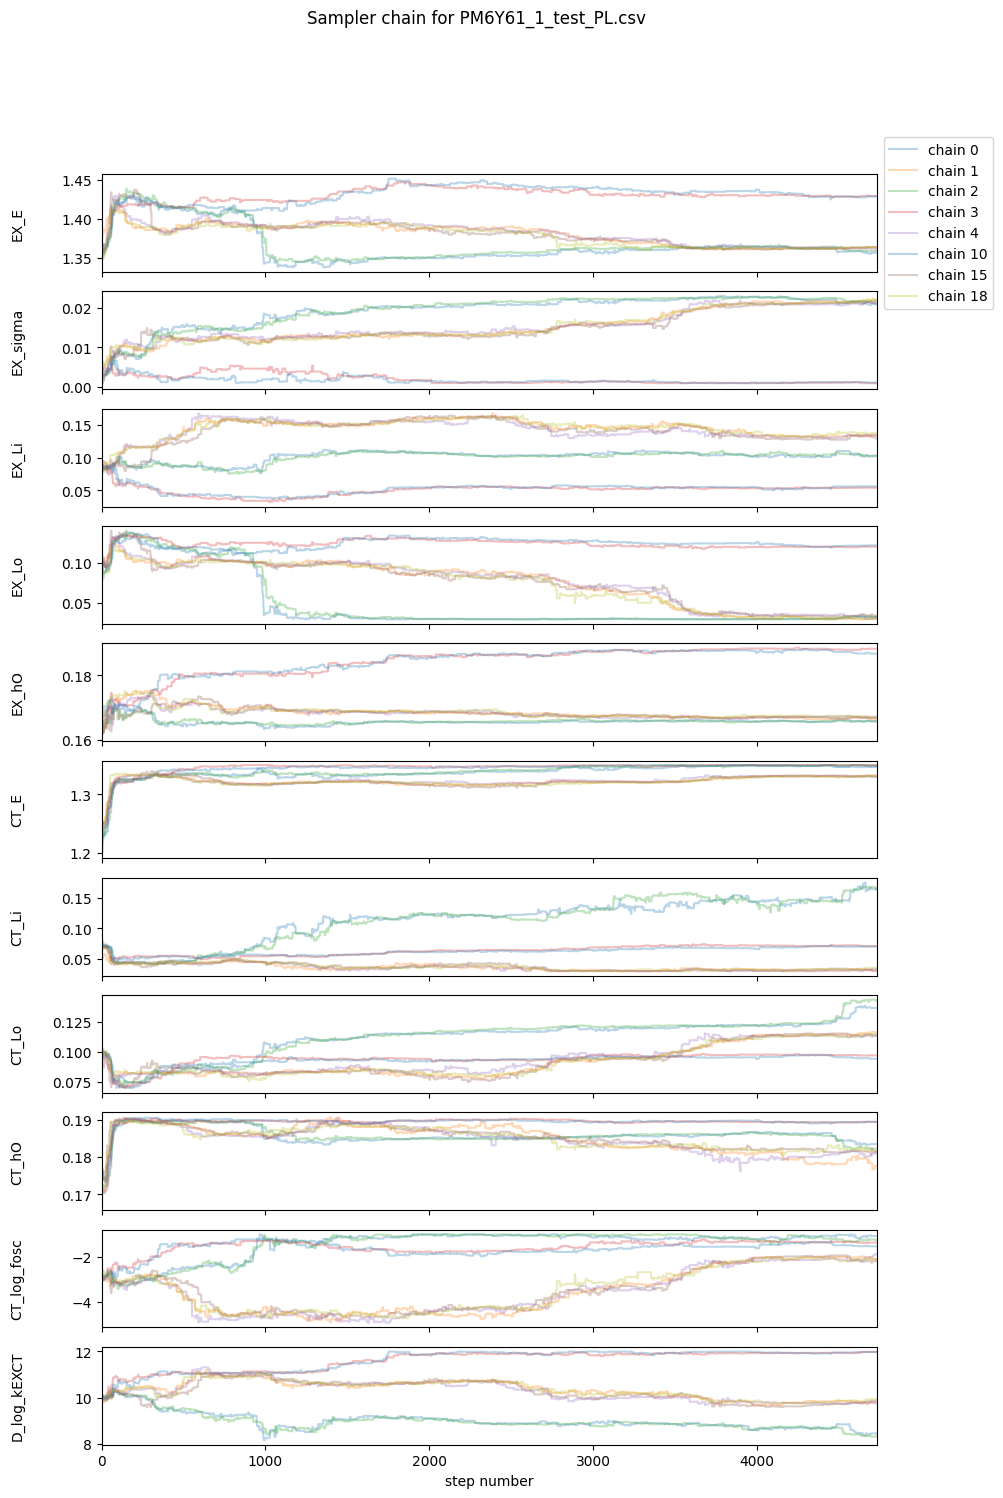

In [16]:
plot_utils.plot_diff_chains(
    reader,
    model_config_save,
    discard=0,
    chains_list=[0, 1, 2, 3, 4, 10, 15, 18],
)

(1.0, 1.6)

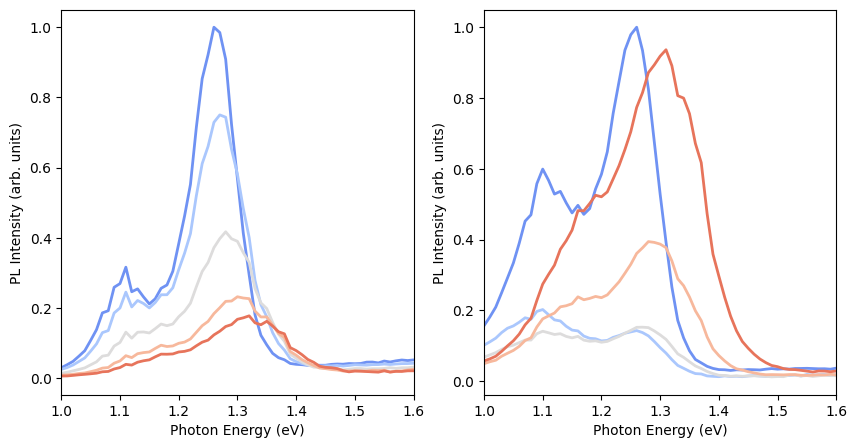

In [17]:
from pl_temp_fit import Exp_data_utils


def plot_plel_data(
    truemodel_pl,
    truemodel_el,
    temperature_list_pl,
    hws_pl,
    temperature_list_el,
    hws_el,
    title="Experimental Data",
):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))

    data_true_plot_pl = truemodel_pl.reshape(len(hws_pl), -1) / max(
        truemodel_pl.reshape(-1, 1)
    )
    data_true_plot_el = truemodel_el.reshape(len(hws_el), -1) / max(
        truemodel_el.reshape(-1, 1)
    )

    import seaborn as sns

    color_list = sns.color_palette("coolwarm", len(temperature_list_pl))
    for i in range(len(temperature_list_pl)):
        ax[0].plot(
            hws_pl,
            data_true_plot_pl[:, i],
            label="" + str(temperature_list_pl[i]) + " K",
            # linestyle="--",
            color=color_list[i],
            linewidth=2,
        )
    for i in range(len(temperature_list_el)):
        ax[1].plot(
            hws_el,
            data_true_plot_el[:, i],
            label="" + str(temperature_list_el[i]) + " K",
            # linestyle="--",
            color=color_list[i],
            linewidth=2,
        )
    ax[0].set_xlabel("Photon Energy (eV)")
    ax[0].set_ylabel("PL Intensity (arb. units)")
    ax[1].set_xlabel("Photon Energy (eV)")
    ax[1].set_ylabel("PL Intensity (arb. units)")

    return fig, ax


Exp_data_pl, temperature_list_pl, hws_pl = Exp_data_utils.read_data(
    model_config_save["csv_name_pl"]
)
Exp_data_el, temperature_list_el, hws_el = Exp_data_utils.read_data(
    model_config_save["csv_name_el"]
)
fig, ax = plot_plel_data(
    Exp_data_pl,
    Exp_data_el,
    temperature_list_pl,
    hws_pl,
    temperature_list_el,
    hws_el,
    title="Experimental Data",
)
ax[0].set_xlim(1, 1.6)
ax[1].set_xlim(1, 1.6)

-1275.650932681302


{'EX': {'E': np.float64(1.357863129725892),
  'sigma': np.float64(0.021412619580545002),
  'Li': np.float64(0.10036920492979198),
  'Lo': np.float64(0.03138926727455884),
  'hO': np.float64(0.16582210323033053)},
 'CT': {'E': np.float64(1.347790694479435),
  'Li': np.float64(0.15801388130400068),
  'Lo': np.float64(0.13397204127422002),
  'hO': np.float64(0.1838685615743603),
  'log_fosc': np.float64(-1.1166810858158849)},
 'D': {'log_kEXCT': np.float64(8.426814942122515)}}

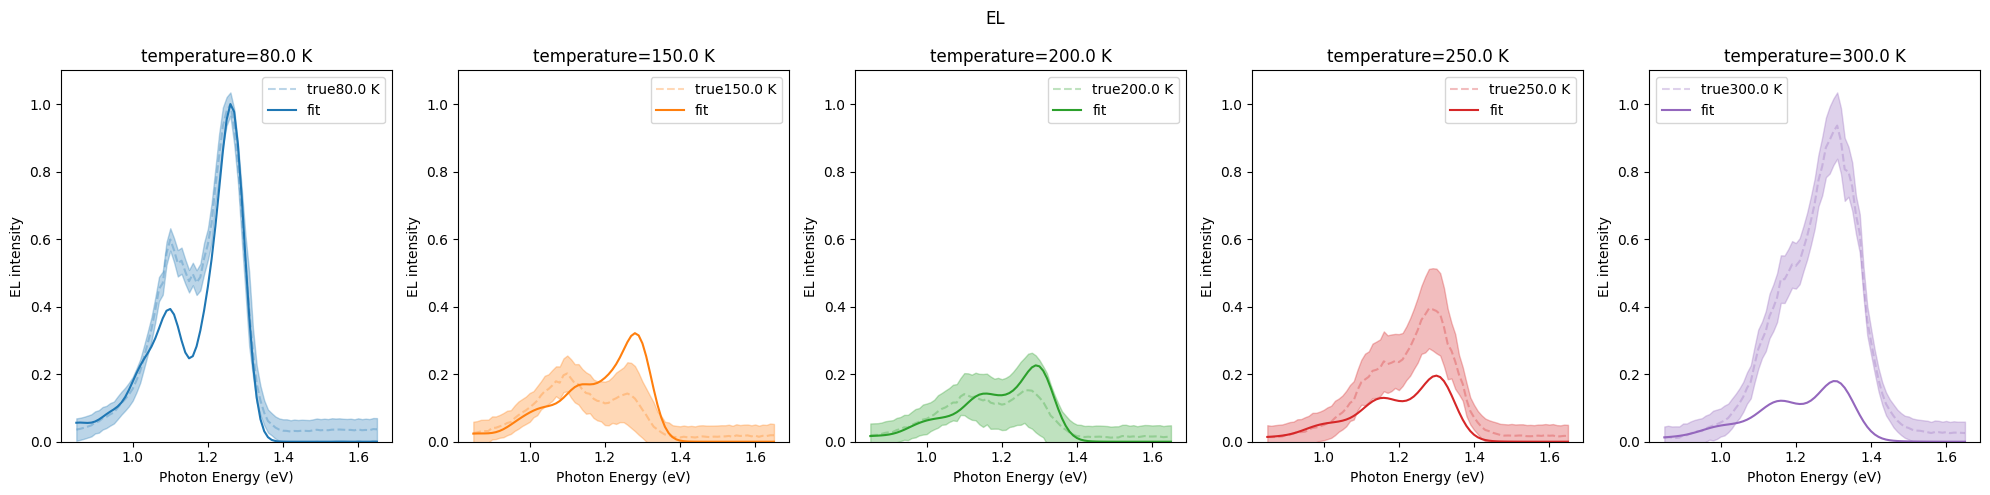

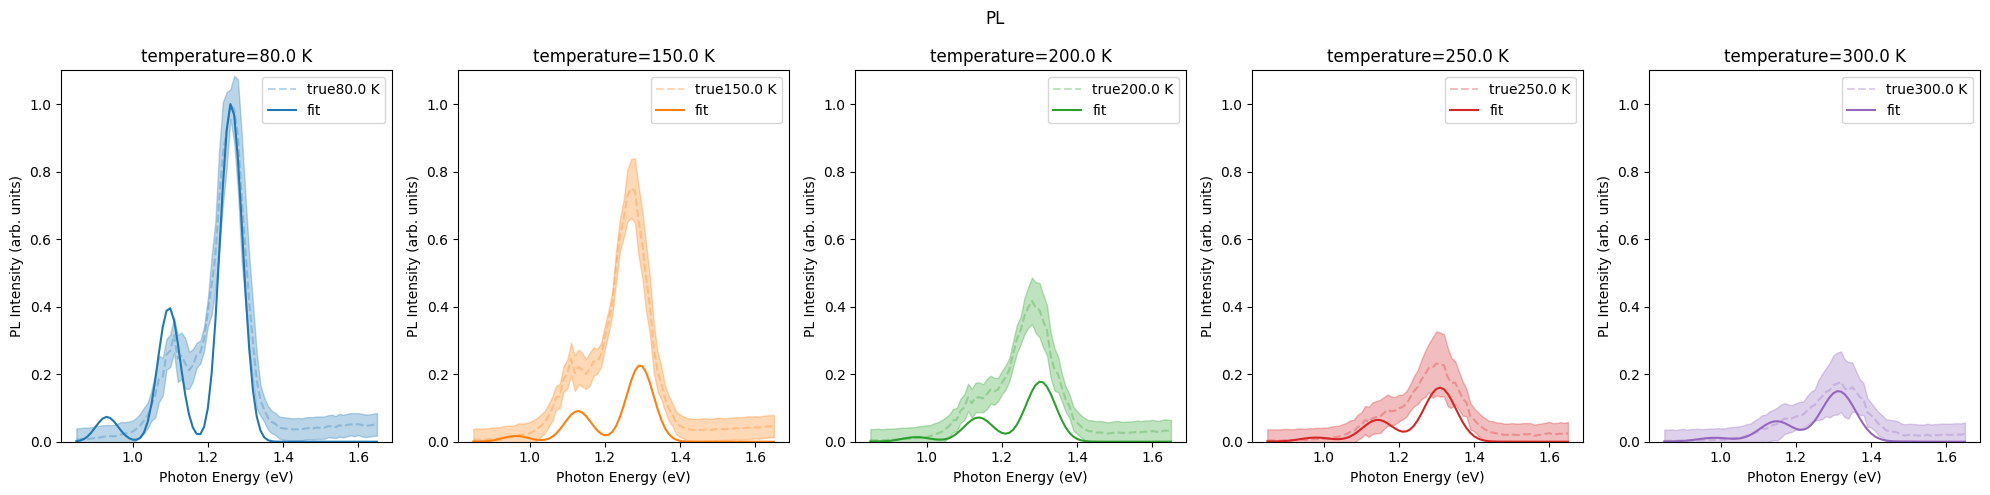

In [18]:
import importlib

from pl_temp_fit import covariance_utils, fit_el_utils, generate_data_utils

importlib.reload(fit_el_utils)
importlib.reload(generate_data_utils)


def plot_fit_results(
    reader,
    model_config_save,
    model_config,
    discard=0,
    filter_log_likelihood=True,
    variance_pl=None,
    variance_el=None,
):
    # Load the model config

    Exp_data_pl, temperature_list_pl, hws_pl = Exp_data_utils.read_data(
        model_config_save["csv_name_pl"]
    )
    Exp_data_el, temperature_list_el, hws_el = Exp_data_utils.read_data(
        model_config_save["csv_name_el"]
    )
    samples = reader.get_chain(discard=discard, flat=True)
    blobs = reader.get_blobs(flat=True, discard=discard)
    if filter_log_likelihood:
        print(max(blobs["log_likelihood"]))

        samples = samples[
            (blobs["log_likelihood"] > max(blobs["log_likelihood"]) * 1.01)
            & (blobs["EX_knr"] < 1e11)
        ]
    sample_num = np.random.randint(0, samples.shape[0])
    data_fit = samples[sample_num, :]
    true_parameters = fit_el_utils.get_param_dict(
        model_config_save["params_to_fit_init"], data_fit
    )

    fixed_parameters_dict, params_to_fit_init, min_bounds, max_bounds = (
        config_utils.get_dict_params(model_config_save)
    )
    model_config["temperature_list_el"] = temperature_list_el
    model_config["hws_el"] = hws_el
    model_config["temperature_list_pl"] = temperature_list_pl
    model_config["hws_pl"] = hws_pl
    if variance_el is None:
        co_var_mat_pl, co_var_mat_el, variance_el, variance_pl = (
            covariance_utils.get_covariance_matrix_for_data(
                model_config,
                fixed_parameters_dict=fixed_parameters_dict,
                params_to_fit=true_parameters,
            )
        )
    fit_el_utils.plot_exp_data_with_variance(
        temperature_list_el,
        hws_el,
        temperature_list_pl,
        hws_pl,
        variance_el,
        variance_pl,
        model_config_save["save_folder"],
        fixed_parameters_dict,
        true_parameters,
        Exp_data_pl,
        Exp_data_el,
    )
    return true_parameters, variance_pl, variance_el


true_parameters, variance_pl, variance_el = plot_fit_results(
    reader,
    model_config_save,
    model_config,
    60,
    True,
)
true_parameters

-1275.650932681302


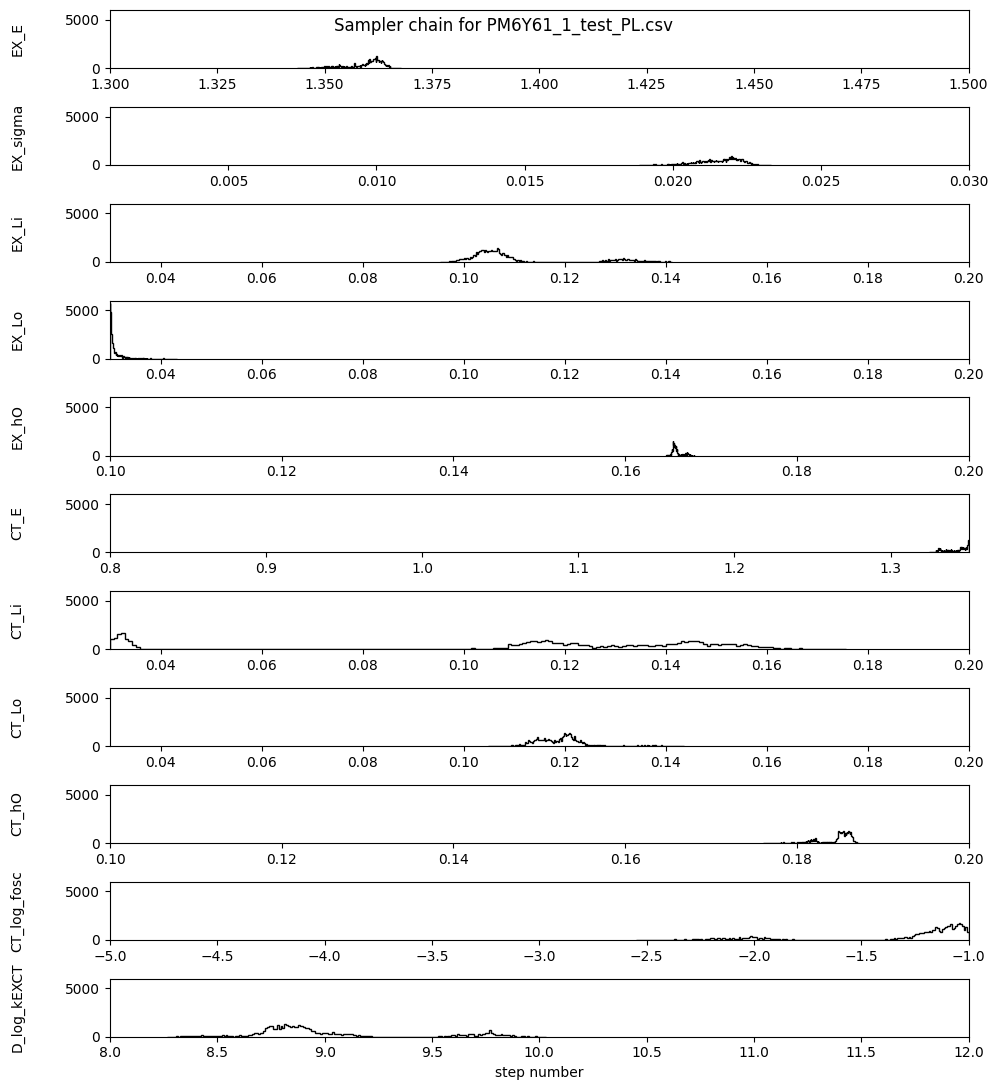

In [20]:
def plot_distribution(
    reader,
    model_config_save,
    discard=0,
    set_axis_limits=True,
    filter_log_likelihood=True,
):
    samples = reader.get_chain(discard=discard, flat=True)
    labels = []
    min_bound, max_bound = {}, {}
    params_to_fit = model_config_save["params_to_fit_init"]
    blobs = reader.get_blobs(flat=True, discard=discard)
    if filter_log_likelihood:
        print(max(blobs["log_likelihood"]))

        samples = samples[
            (blobs["log_likelihood"] > max(blobs["log_likelihood"]) * 1.1)
            & (blobs["EX_knr"] < 1e11)
        ]

    for key in params_to_fit.keys():
        for keys in params_to_fit[key].keys():
            labels.append(f"{key}_{keys}")
            min_bound[f"{key}_{keys}"] = model_config_save["min_bounds"][key][
                keys
            ]
            max_bound[f"{key}_{keys}"] = model_config_save["max_bounds"][key][
                keys
            ]
    ndim = len(labels)
    fig, axes = plt.subplots(ndim, figsize=(10, ndim * 1), sharey=True)
    for i in range(ndim):
        ax = axes[i]
        ax.hist(samples[:, i], 200, color="k", histtype="step")
        ax.set_ylabel(labels[i])
        ax.yaxis.set_label_coords(-0.1, 0.5)
        ax.set_xlim(min_bound[ax.get_ylabel()], max_bound[ax.get_ylabel()])
    axes[-1].set_xlabel("step number")
    fig.tight_layout()
    fig.suptitle(
        f"Sampler chain for {model_config_save['csv_name_pl'].split('/')[-1]}"
    )

    fig.show()


plot_distribution(
    reader, model_config_save, discard=1200, filter_log_likelihood=True
)

-1275.650932681302


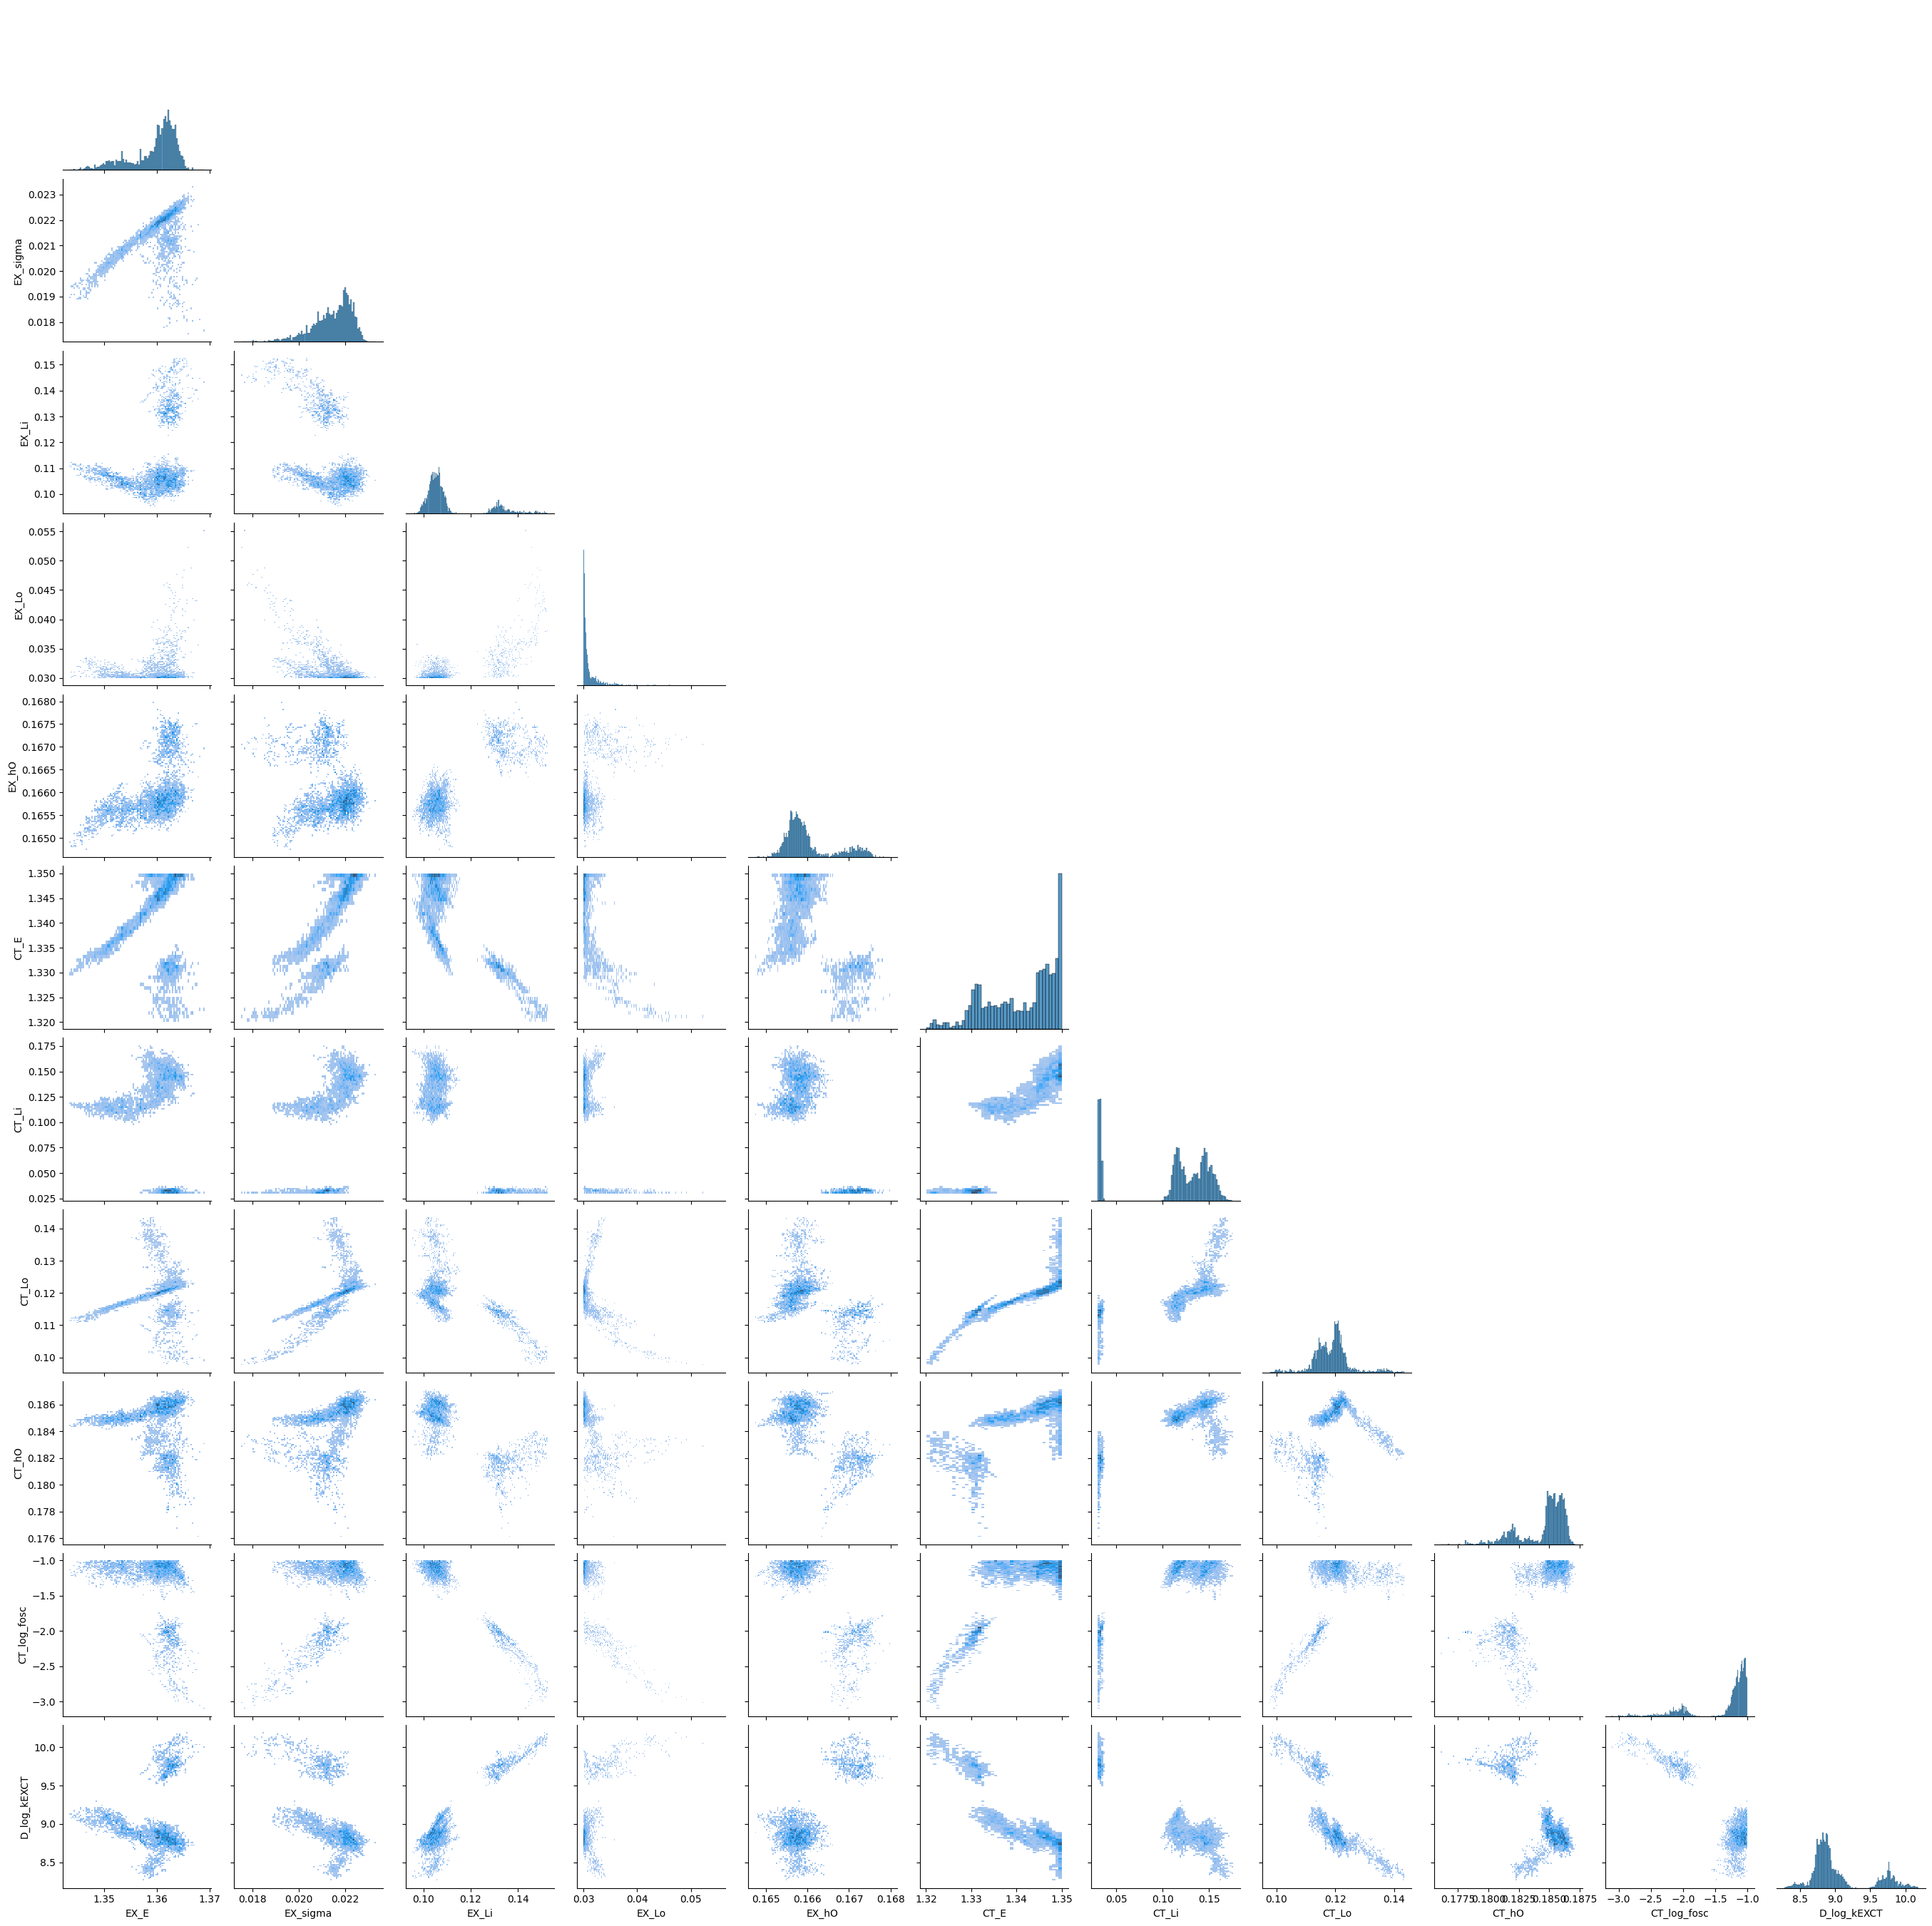

In [21]:
# plot a pair grid plot
import seaborn as sns


# plot posterior predictive
def plot_pair_plot(
    reader,
    model_config_save,
    discard=0,
    set_axis_limits=True,
    filter_log_likelihood=True,
):
    samples = reader.get_chain(discard=discard, flat=True)
    blobs = reader.get_blobs(flat=True, discard=discard)
    if filter_log_likelihood:
        print(max(blobs["log_likelihood"]))

        samples = samples[
            blobs["log_likelihood"] > max(blobs["log_likelihood"]) * 1.1
        ]
    labels = []
    min_bound, max_bound = {}, {}
    params_to_fit = model_config_save["params_to_fit_init"]
    for key in params_to_fit.keys():
        for keys in params_to_fit[key].keys():
            labels.append(f"{key}_{keys}")
            min_bound[f"{key}_{keys}"] = model_config_save["min_bounds"][key][
                keys
            ]
            max_bound[f"{key}_{keys}"] = model_config_save["max_bounds"][key][
                keys
            ]

    ndim = len(labels)
    df_samples = pd.DataFrame(samples, columns=labels)
    g = sns.pairplot(df_samples, kind="hist", corner=True)
    if set_axis_limits:
        for i, ax in enumerate(g.figure.axes):
            if ax.get_xlabel() in min_bound:
                ax.set_xlim(
                    min_bound[ax.get_xlabel()], max_bound[ax.get_xlabel()]
                )
            if ax.get_ylabel() in min_bound:
                ax.set_ylim(
                    min_bound[ax.get_ylabel()], max_bound[ax.get_ylabel()]
                )
    g.figure.show()
    return g


g = plot_pair_plot(
    reader, model_config_save, discard=500, set_axis_limits=False
)

number of iterations 4731


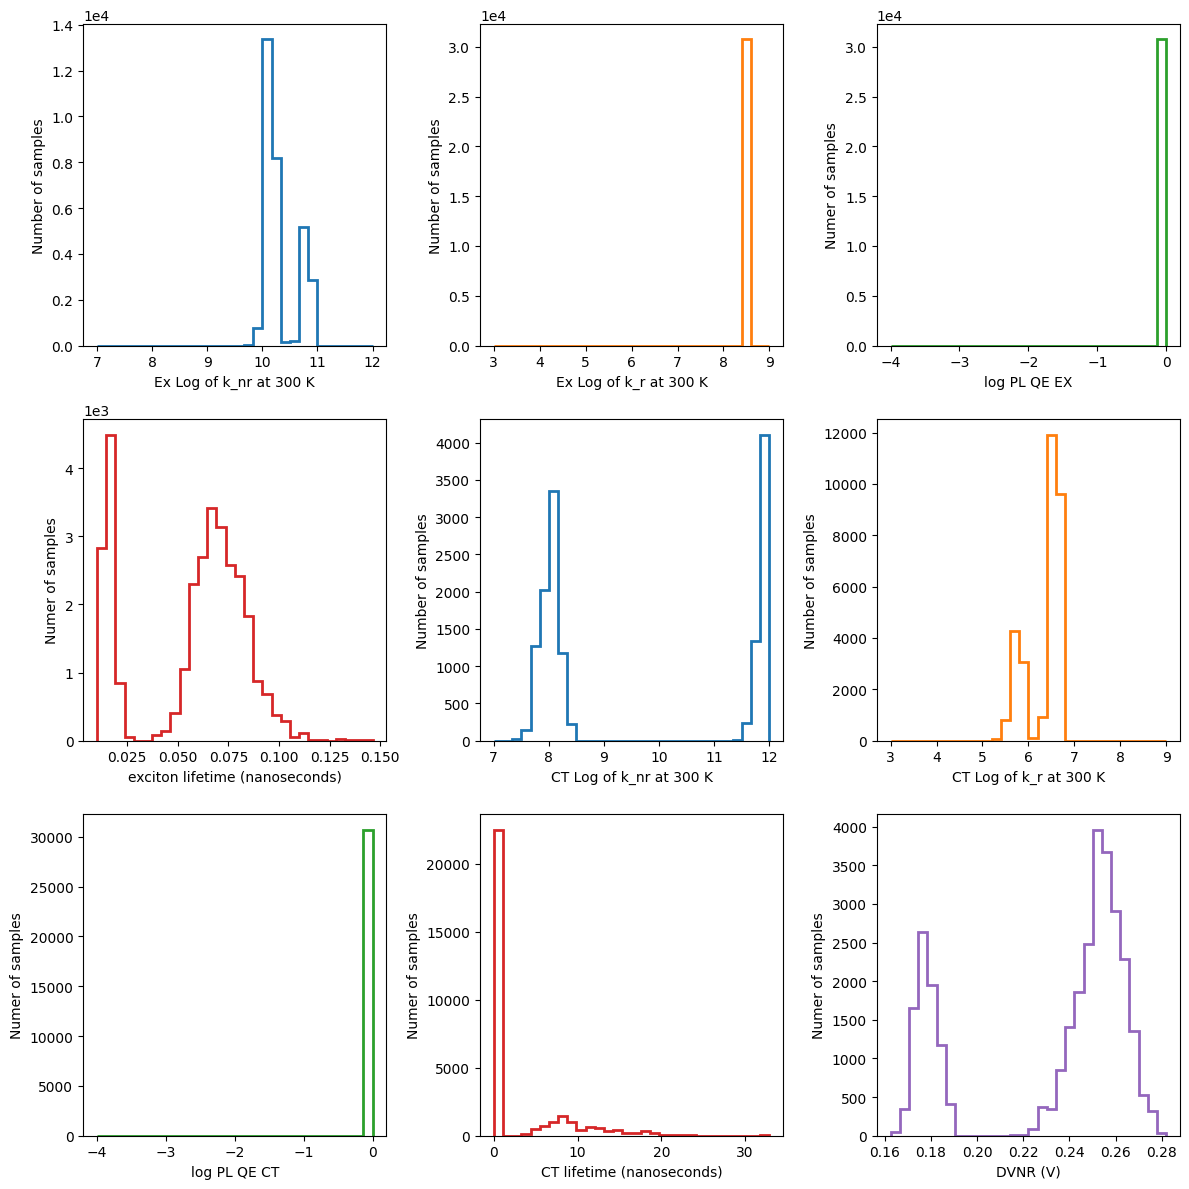

In [23]:
def plot_voltage_losses(
    reader,
    range_chi_square=(7, 11),
    range_log_prior=(7, 11),
    discard=5,
    temperature=300,
    filter_log_likelihood=False,
):
    """Plot the lifetime distribution from the sampling output
    reader: the reader object from the emcee sampler
    range_chi_square: the range for the chi square plot
    range_log_prior: the range for the log prior plot
    discard: the number of samples to discard
    temperature: the temperature at which the lifetime is calculated
    """
    print("number of iterations", reader.iteration)
    blobs = reader.get_blobs(flat=True, discard=discard)
    if filter_log_likelihood:
        blobs = blobs[
            blobs["log_likelihood"] > max(blobs["log_likelihood"]) * 1.1
        ]
        blobs = blobs[blobs["EX_knr"] < 1e11]
    fig, ax = plt.subplots(3, 3, figsize=(12, 12))

    ax = ax.flatten()
    ax[0].hist(
        np.log10(blobs["EX_knr"]),
        30,
        histtype="step",
        range=(7, 12),
        color="C" + str(0),
        linewidth=2,
    )
    ax[0].set_xlabel("Ex Log of k_nr at " + str(temperature) + " K")
    ax[0].set_ylabel("Number of samples")
    ax[1].hist(
        np.log10(blobs["EX_kr"]),
        30,
        histtype="step",
        range=(3, 9),
        color="C" + str(1),
        linewidth=2,
    )
    ax[1].set_xlabel("Ex Log of k_r at " + str(temperature) + " K")
    ax[1].set_ylabel("Number of samples")
    pl_QE = blobs["EX_knr"] / (blobs["EX_kr"] + blobs["EX_knr"])
    ax[2].hist(
        np.log10(pl_QE),
        30,
        histtype="step",
        range=(-4, 0),
        color="C" + str(2),
        linewidth=2,
    )
    ax[2].set_xlabel("log PL QE EX")
    ax[2].set_ylabel("Numer of samples")
    lifetime = 1 / (blobs["EX_kr"] + blobs["EX_knr"])
    ax[3].hist(
        lifetime * 1e9,
        30,
        histtype="step",
        color="C" + str(3),
        linewidth=2,
    )
    ax[3].set_xlabel("exciton lifetime (nanoseconds)")
    ax[3].set_ylabel("Numer of samples")
    # do the same thing for the CT
    ax[4].hist(
        np.log10(blobs["CT_knr"]),
        30,
        histtype="step",
        range=(7, 12),
        color="C" + str(0),
        linewidth=2,
    )
    ax[4].set_xlabel("CT Log of k_nr at " + str(temperature) + " K")
    ax[4].set_ylabel("Number of samples")
    ax[5].hist(
        np.log10(blobs["CT_kr"]),
        30,
        histtype="step",
        range=(3, 9),
        color="C" + str(1),
        linewidth=2,
    )
    ax[5].set_xlabel("CT Log of k_r at " + str(temperature) + " K")
    ax[5].set_ylabel("Number of samples")
    pl_QE = blobs["CT_knr"] / (blobs["CT_kr"] + blobs["CT_knr"])
    ax[6].hist(
        np.log10(pl_QE),
        30,
        histtype="step",
        range=(-4, 0),
        color="C" + str(2),
        linewidth=2,
    )
    ax[6].set_xlabel("log PL QE CT")
    ax[6].set_ylabel("Numer of samples")
    lifetime = 1 / (blobs["CT_kr"] + blobs["CT_knr"])
    ax[7].hist(
        lifetime * 1e9,
        30,
        histtype="step",
        color="C" + str(3),
        linewidth=2,
    )
    ax[7].set_xlabel("CT lifetime (nanoseconds)")
    ax[7].set_ylabel("Numer of samples")
    ax[8].hist(
        blobs["DVNR"],
        30,
        histtype="step",
        color="C" + str(4),
        linewidth=2,
    )
    ax[8].set_xlabel("DVNR (V)")
    ax[8].set_ylabel("Numer of samples")
    # set y ticks to exponent form
    for i in range(4):
        ax[i].ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    fig.tight_layout()
    plt.show()


plot_voltage_losses(reader, discard=3000, filter_log_likelihood=True)